In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import pandas as pd

In [2]:
#read data
ambition=pd.read_pickle('data/temp/ambition.pkl')
credits=pd.read_pickle('data/temp/credits_prices.pkl')
missing_credits=pd.read_pickle('data/temp/missing_credits_prices.pkl').rename(columns={'Quantity Issued':'credit_retired'})
#companies=pd.read_excel('data/company_data/Data.xlsx', sheet_name='company_data')

control_var=pd.read_pickle('data/temp/combined_control.pkl')

#centrality=pd.read_excel('data/company_data/Data.xlsx', sheet_name='Centrality').set_index('CDP_ID')

scope1=pd.read_pickle('data/temp/scope1_total.pkl')

emission_overwrite=pd.read_excel('data/company_data/Data.xlsx', sheet_name='emission_overwrite').set_index('CDP_ID')

ets_costs=pd.read_pickle('data/ets_costs.pkl')



for i in emission_overwrite.index:
    if emission_overwrite.loc[i, 'scope1_2023']>0:
        scope1.loc[i, 'scope1_2023']=float(emission_overwrite.loc[i, 'scope1_2023'])
    if emission_overwrite.loc[i, 'scope1_2018']>0:
        scope1.loc[i, 'scope1_2018']=float(emission_overwrite.loc[i, 'scope1_2018'])


# Summing the 'money_spent' column grouped by 'Account number' and 'CDP_ID'
credits_id = credits.groupby('Account number')['money_spent'].sum().reset_index()
missing_credits_id = missing_credits.groupby('CDP_ID')['money_spent'].sum().reset_index()

# Drop entries from credits_id that have an Account number present in missing_credits_id['CDP_ID']
filtered_credits_id = credits_id[~credits_id['Account number'].isin(missing_credits_id['CDP_ID'])]

# Rename the column in missing_credits_id to match credits_id
missing_credits_id.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# Concatenate the filtered credits_id and missing_credits_id
combined_credits = pd.concat([filtered_credits_id, missing_credits_id], ignore_index=True)

# If you need to group by 'Account number' again to sum the totals
final_credits = combined_credits.groupby('Account number')['money_spent'].sum()

credits_id=final_credits


# Summing the 'money_spent' column grouped by 'Account number' and 'CDP_ID'
credits_no = credits.groupby('Account number')['credit_retired'].sum().reset_index()
missing_credits_no = missing_credits.groupby('CDP_ID')['credit_retired'].sum().reset_index()

# Drop entries from credits_id that have an Account number present in missing_credits_id['CDP_ID']
filtered_credits_no = credits_no[~credits_no['Account number'].isin(missing_credits_no['CDP_ID'])]

# Rename the column in missing_credits_id to match credits_id
missing_credits_no.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# Concatenate the filtered credits_id and missing_credits_id
combined_credit_number = pd.concat([filtered_credits_no, missing_credits_no], ignore_index=True)

# If you need to group by 'Account number' again to sum the totals
final_credits_number = combined_credit_number.groupby('Account number')['credit_retired'].sum()

credit_number=final_credits_number

credit_number.to_pickle('data/temp/credit_number.pkl')


ambition['credit_spent_ecosystem_marketplace']=credits_id
ambition['credit_spent_ecosystem_marketplace']=ambition['credit_spent_ecosystem_marketplace'].fillna(0)

ambition['offset_share']=(100*(credit_number/scope1['scope1_2023']).replace(np.nan, 0))
ambition['credit_number']=credit_number
ambition['credit_number']=ambition['credit_number'].fillna(0)

ambition['credit_spent_observed_min']=ambition['credit_number']*3.72


reporting_years=pd.read_excel('data/company_data/Data.xlsx', sheet_name='Reporting_year').set_index('CDP_ID')


In [3]:
#match the the control data with the ambition data based on reporting year
reporting_years['end_year']=reporting_years['end_date'].dt.year
control_var=control_var.set_index('CDP_ID')
control_var['capex']=np.nan
for i in control_var.index:
    if i in reporting_years.index:
   
        if reporting_years.loc[i,'end_year']==2022:
            control_var.loc[i,'capex']=control_var.loc[i,'CAPEX_FY2022']
        elif reporting_years.loc[i,'end_year']==2023:
            control_var.loc[i,'capex']=control_var.loc[i,'CAPEX_FY2023']
control_var=control_var.reset_index()

regression_df = pd.merge(ambition, control_var[['CDP_ID', 'TOTAL_REV_FY2023','TOTAL_REV_FY2022', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','CAPEX_FY2023','CAPEX_FY2022','capex','Continent']], on='CDP_ID', how='left')


## CAPEX Share spent on carbon credits

In [4]:
#calculate the capex share
df=regression_df[['CDP_ID','index','credit_spent_ecosystem_marketplace','credit_spent_observed_min','TOTAL_REV_FY2023', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','CAPEX_FY2023','CAPEX_FY2022','capex','Continent','Sector']]

#calculate the capex shares - factor adjust for reporting style from S&P captial IQ in 1000 USD
df['capex_share_min']=-100*df['credit_spent_observed_min']/(df['capex']*1000)
df['capex_share_max']=-100*df['credit_spent_ecosystem_marketplace']/(df['capex']*1000)

df['capex_share_reported']=np.nan


#add reported data from easyjet and Delta Air Lines
df.loc[df['CDP_ID'] == 4408, 'capex_share_reported'] = -100 * 116000000 / (df.loc[df['CDP_ID'] == 4408, 'capex'] * 1000)
df.loc[df['CDP_ID'] == 5170, 'capex_share_reported'] = -100 * (1.2369 * 14000000) / (df.loc[df['CDP_ID'] == 5170, 'capex'] * 1000)


df.loc[df['CDP_ID'] == 50174, 'capex_share_max' ]=0
df.loc[df['CDP_ID'] == 50174, 'capex_share_min' ]=0

df=df.set_index('CDP_ID')
df['ets_costs']=ets_costs
df['ets_costs']=df['ets_costs'].fillna(0)
df=df.reset_index()


df['ets_share']=-100*df['ets_costs']/(df['CAPEX_FY2022']*1000)


df['ets_offset_ratio_min']=(df['ets_costs']/df['credit_spent_ecosystem_marketplace']).fillna(0)
df['ets_offset_ratio_max']=(df['ets_costs']/df['credit_spent_observed_min']).fillna(0)


/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_39309/1127604495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capex_share_min']=-100*df['credit_spent_observed_min']/(df['CAPEX_FY2022']*1000)
/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_39309/1127604495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capex_share_max']=-100*df['credit_spent_ecosystem_marketplace']/(df['CAPEX_FY2022']*1000)
/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_39309/1127604495.p

In [5]:
df[df['index'].str.contains('Luftha')]

,CDP_ID,index,credit_spent_ecosystem_marketplace,credit_spent_observed_min,TOTAL_REV_FY2023,EBITDA_FY2023,TOTAL_ASSETS_FY2023,CAPEX_FY2023,CAPEX_FY2022,capex,Continent,Sector,capex_share_min,capex_share_max,capex_share_reported,ets_costs,ets_share,ets_offset_ratio_min,ets_offset_ratio_max
66,4657,Deutsche Lufthansa,3648150.0,1841400.0,38365803.536395,4258901.60187,50095059.135625,-4380028.310709,-2642201.916394,-2.642202e+06,Europe,Airline,0.069692,0.138072,NaN,2.068505e+08,7.828716,56.700105,112.333272


In [6]:
1018/31000000

3.2838709677419356e-05

In [7]:
1018/31

32.83870967741935

In [8]:
df_plot=df[['index', 'capex_share_min','capex_share_max', 'capex_share_reported','ets_share', 'ets_offset_ratio_min','ets_offset_ratio_max']]


In [9]:
df_plot['capex_share_max']=df_plot['capex_share_max'].astype(float)
df_plot['capex_share_min']=df_plot['capex_share_min'].astype(float)

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_39309/1139175910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['capex_share_max']=df_plot['capex_share_max'].astype(float)
/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_39309/1139175910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['capex_share_min']=df_plot['capex_share_min'].astype(float)


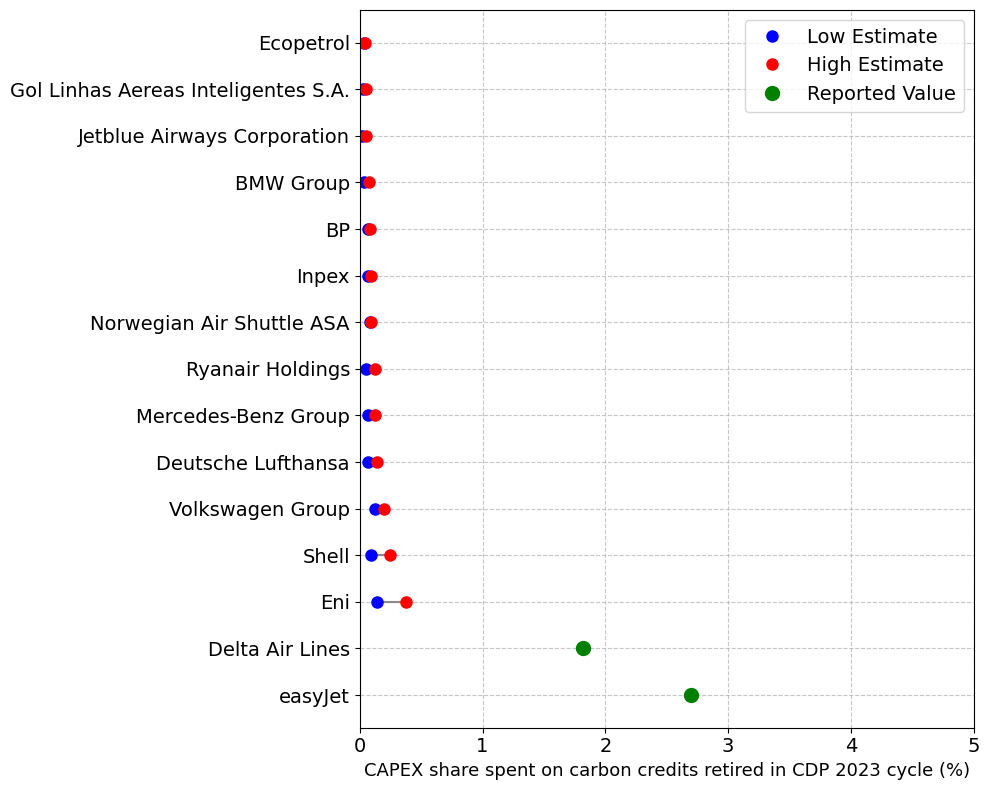

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_plot is your plotting dataframe
# Extract top 15 entries with the largest capex_share_max
df_top15 = df_plot.nlargest(15, 'capex_share_max')

# Sort by capex_share_max in descending order for clear visualization
df_top15 = df_top15.sort_values('capex_share_max', ascending=False)

# Separate rows with non-NaN 'capex_share_reported'
reported_mask = df_top15['capex_share_reported'].notna()
df_reported = df_top15[reported_mask]
df_non_reported = df_top15[~reported_mask]

# Plotting the dumbbell chart
plt.figure(figsize=(10, 8))

plt.hlines(y=df_top15['index'], xmin=df_top15['capex_share_min'], xmax=df_top15['capex_share_max'], color='white', alpha=0.0)
plt.hlines(y=df_top15[df_top15['capex_share_reported'].isna()]['index'], xmin=df_top15['capex_share_min'][df_top15['capex_share_reported'].isna()], xmax=df_top15['capex_share_max'][df_top15['capex_share_reported'].isna()], color='grey', alpha=0.9)

# Plot points for capex_share_min and capex_share_max
plt.plot(df_non_reported['capex_share_min'], df_non_reported['index'], "o", color='blue',ms=8, label='Low Estimate')
plt.plot(df_non_reported['capex_share_max'], df_non_reported['index'], "o", color='red',ms=8,  label='High Estimate')

# Plot single points for reported capex_share_reported
plt.plot(df_reported['capex_share_reported'], df_reported['index'], "o", color='green', ms=10, label='Reported Value')

# Adding labels and title
plt.xlabel('CAPEX share spent on carbon credits retired in CDP 2023 cycle (%)', fontsize=13)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)




plt.xlim(0, 5)
# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)




# Updating legend to include all plot elements
plt.legend(fontsize=14)

# Display the plot
plt.tight_layout()
plt.savefig('visualization/figures/capex_share/capex_share.png', dpi=600)


In [18]:
df_top15.to_clipboard()

### Emission Share Offset

In [12]:
#get emission and credit data
scope1=pd.read_pickle('data/temp/scope1_total.pkl')
scope2=pd.read_pickle('data/temp/scope2_total.pkl')
scope3=pd.read_pickle('data/temp/scope3.pkl')

credits_retired=pd.read_pickle('data/temp/credit_number.pkl')

#convert to numeric
scope3['scope3_emissions']=pd.to_numeric(scope3['scope3_emissions'], errors='coerce')
scope2['scope2_location_based']=pd.to_numeric(scope2['scope2_2023'], errors='coerce')

scope1['scope1_2023']=pd.to_numeric(scope1['scope1_2023'], errors='coerce')
scope3=scope3[['Account number','Organization','scope3_emissions']].groupby(['Account number','Organization'])['scope3_emissions'].sum().reset_index().set_index('Account number')

scope1=scope1[['company_name', 'scope1_2023']]



scope2=scope2[[ 'company_name', 'scope2_location_based']]


In [13]:
scope2

,company_name,scope2_location_based
19290,Toyota Motor Corporation,3810000.000
20309,Volkswagen AG,4650011.000
866803,Mercedes-Benz Group AG,1121000.000
1932,BMW AG,1187339.000
7164,General Motors Company,2996074.000
...,...,...
59365,Chorus Aviation,3053.000
10289,Korean Air Lines Co Ltd,43301.000
9703,Japan Airlines Corporation,54331.000
50174,Avianca Group,5001.200


In [14]:
#get credit data
credits=pd.read_pickle('data/temp/credits_prices.pkl')
missing_credits=pd.read_pickle('data/temp/missing_credits_prices.pkl').rename(columns={'Quantity Issued':'credit_retired'})
# Summing the 'money_spent' column grouped by 'Account number' and 'CDP_ID'
credits_no = credits.groupby('Account number')['credit_retired'].sum().reset_index()
missing_credits_no = missing_credits.groupby('CDP_ID')['credit_retired'].sum().reset_index()

# Drop entries from credits_id that have an Account number present in missing_credits_id['CDP_ID']
filtered_credits_no = credits_no[~credits_no['Account number'].isin(missing_credits_no['CDP_ID'])]

# Rename the column in missing_credits_id to match credits_id
missing_credits_no.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# Concatenate the filtered credits_id and missing_credits_id
combined_credit_number = pd.concat([filtered_credits_no, missing_credits_no], ignore_index=True)

# If you need to group by 'Account number' again to sum the totals
final_credits_number = combined_credit_number.groupby('Account number')['credit_retired'].sum()

credit_number=final_credits_number

In [15]:
# compile df
data=scope3
data['scope1']=scope1['scope1_2023']
data['scope2']=scope2['scope2_location_based']
data['credits_retired']=credits_retired

data.loc[50174, 'credits_retired']=0

data=data[data['credits_retired']>10000]


data=data.rename(columns={'Organization':'company_name', 'scope3_emissions':'scope3'})


data.loc[5170,'company_name']='easyJet*'
data.loc[4408,'company_name']='Delta Air Lines**'

data.loc[5170,'scope2']=0

data=data.sort_values(by='credits_retired', ascending=True)


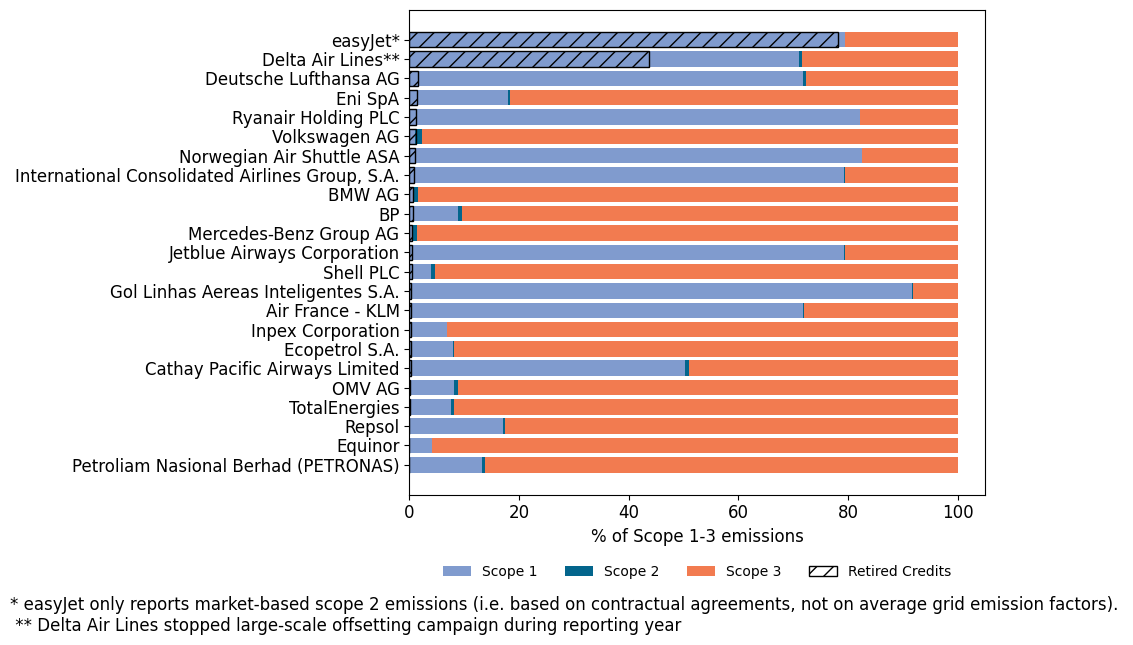

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


#plot for scope 1 - 3 

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate the total for each company
df['total'] = df[['scope1', 'scope2', 'scope3']].sum(axis=1)

# Calculate percentages for each scope
df['scope_1_pct'] = df['scope1'] / df['total'] * 100
df['scope_2_pct'] = df['scope2'] / df['total'] * 100
df['scope_3_pct'] = df['scope3'] / df['total'] * 100
df['credits_retired_pct'] = df['credits_retired'] / df['total'] * 100

df=df.sort_values(by='credits_retired_pct', ascending=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax.barh(df['company_name'], df['scope_1_pct'], color='#809bce', label='Scope 1')
ax.barh(df['company_name'], df['scope_2_pct'], left=df['scope_1_pct'], color='#03658c', label='Scope 2')
ax.barh(df['company_name'], df['scope_3_pct'], left=df['scope_1_pct'] + df['scope_2_pct'], color='#f27b50', label='Scope 3')

# Overlay the hatched bars for Retired Credits
ax.barh(df['company_name'], df['credits_retired_pct'], color='none', edgecolor='black', hatch='//', label='Retired Credits')

# Set labels
ax.set_xlabel('% of Scope 1-3 emissions', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)


# Add legend
#ax.legend(loc='upper right')

# Move the legend to outside the plot area
#ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False)


# Add custom text at the bottom of the figure
#fig.text(0.01, -0.06, '* easyJet only reports market-based scope 1  emissions\n ** Delta Air Lines stopped large-scale offsetting campaign during reporting year', ha='left', fontsize=12)
#fig.text(0.1, 0.01, '* Delta Air Lines stopped large-scale offsetting campaign during reporting year', ha='center', fontsize=10)
fig.text(0.01, -0.06, '* easyJet only reports market-based scope 2 emissions (i.e. based on contractual agreements, not on average grid emission factors). \n ** Delta Air Lines stopped large-scale offsetting campaign during reporting year', ha='left', fontsize=12)


# Show the plot
plt.tight_layout()
plt.savefig('visualization/figures/Offset_share/offset_share.png', dpi=600)


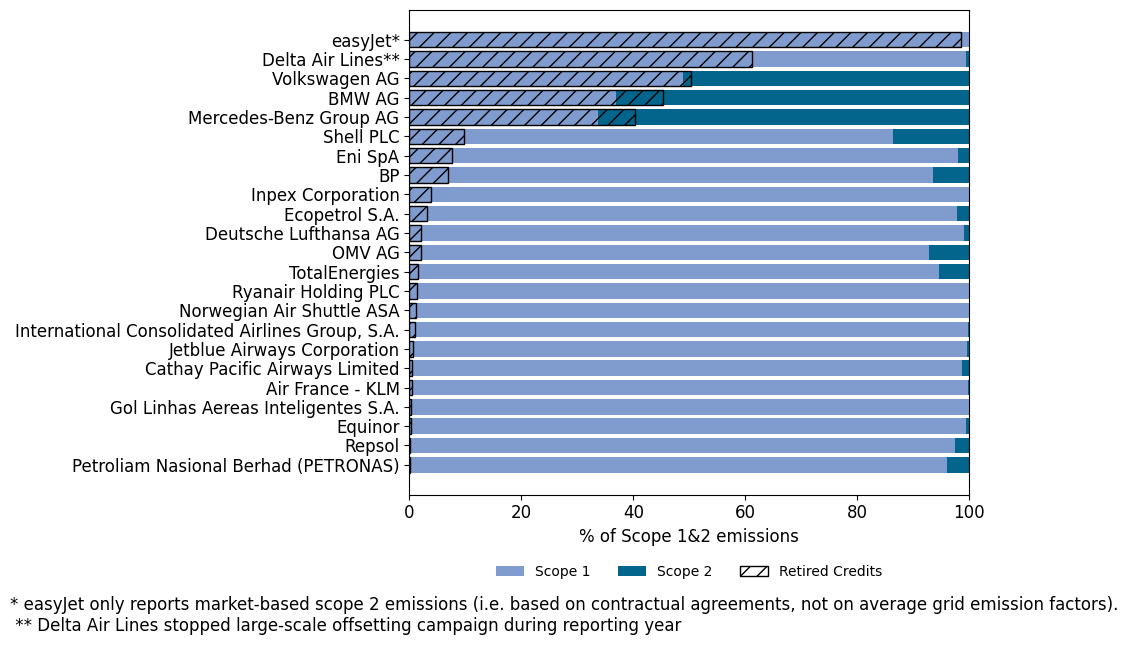

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot for scope 1 and 2

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate the total for each company
df['total'] = df[['scope1', 'scope2']].sum(axis=1)

# Calculate percentages for each scope
df['scope_1_pct'] = df['scope1'] / df['total'] * 100
df['scope_2_pct'] = df['scope2'] / df['total'] * 100

df['credits_retired_pct'] = df['credits_retired'] / df['total'] * 100

df=df.sort_values(by='credits_retired_pct', ascending=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax.barh(df['company_name'], df['scope_1_pct'], color='#809bce', label='Scope 1')
ax.barh(df['company_name'], df['scope_2_pct'], left=df['scope_1_pct'], color='#03658c', label='Scope 2')

# Overlay the hatched bars for Retired Credits
ax.barh(df['company_name'], df['credits_retired_pct'], color='none', edgecolor='black', hatch='//', label='Retired Credits')

# Set labels
ax.set_xlabel('% of Scope 1&2 emissions', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)



# Add legend
#ax.legend(loc='upper right')

# Move the legend to outside the plot area
#ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False)


# Add custom text at the bottom of the figure
fig.text(0.01, -0.06, '* easyJet only reports market-based scope 2 emissions (i.e. based on contractual agreements, not on average grid emission factors). \n ** Delta Air Lines stopped large-scale offsetting campaign during reporting year', ha='left', fontsize=12)
#fig.text(0.1, 0.01, '* Delta Air Lines stopped large-scale offsetting campaign during reporting year', ha='center', fontsize=10)


# Show the plot
plt.tight_layout()
plt.savefig('visualization/figures/Offset_share/offset_share_scope12.png', dpi=600)